# 1) Predict locations of Region of Interest (ROI)

## 1.1) Download required files 

In [1]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2021-03-04 09:48:37--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2021-03-04 09:48:37 (9.59 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



## 1.2) Extract the saved model

In [2]:
%%bash
unzip saved_model.zip
mv content/inference_graph/saved_model/label_map.pbtxt ./
mkdir dataset
mv content/inference_graph/saved_model/test_labels.csv ./dataset/
mkdir dataset/images
mkdir dataset/images/test
cp content/inference_graph/saved_model/test/* ./dataset/images/test

Archive:  saved_model.zip
   creating: content/inference_graph/saved_model/
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/label_map.pbtxt  
  inflating: content/inference_graph/saved_model/test_labels.csv  
  inflating: content/inference_graph/saved_model/saved_model.pb  
   creating: content/inference_graph/saved_model/test/
  inflating: content/inference_graph/saved_model/test/image_016_sharpness_201.jpg  
  inflating: content/inference_graph/saved_model/test/image_009_contrast_115.jpg  
  inflating: content/inference_graph/saved_model/test/image_041_contrast_498.jpg  
  inflating: content/inference_graph/saved_model/test/image_013_sharpness_166.jpg  
  inflating: content/inference_graph/saved_model/test/image_037_sharpness_455.jpg  
  inflating: content/in

## 1.3) Recall model configurations

In [3]:
output_directory = 'inference_graph'
labelmap_path = 'label_map.pbtxt'

import tensorflow as tf
from object_detection.utils import label_map_util
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'content/{output_directory}/saved_model')

## 1.4) Select images to be tested

In [7]:
import pandas as pd
import os
import glob
from pdf2image import convert_from_path

input_path = 'test/'
images = os.listdir(input_path)

for i in range(len(images)):
    if images[i][-4:] == '.jpg':
        pass
    elif images[i][-4:] == '.pdf':
        pages = convert_from_path(input_path+images[i])
        for page in pages:
            page.save(input_path +'pdf_image_' +str(i).zfill(3)+ '.jpg', 'JPEG')
            
images = sorted(glob.glob1(input_path, "*.jpg"))
images

['pdf_image_003.jpg',
 'seen_image_001.jpg',
 'seen_image_002.jpg',
 'seen_image_003.jpg',
 'unseen_image_001.jpg',
 'unseen_image_002.jpg',
 'unseen_image_003.jpg']

## 1.5) Test the detection model

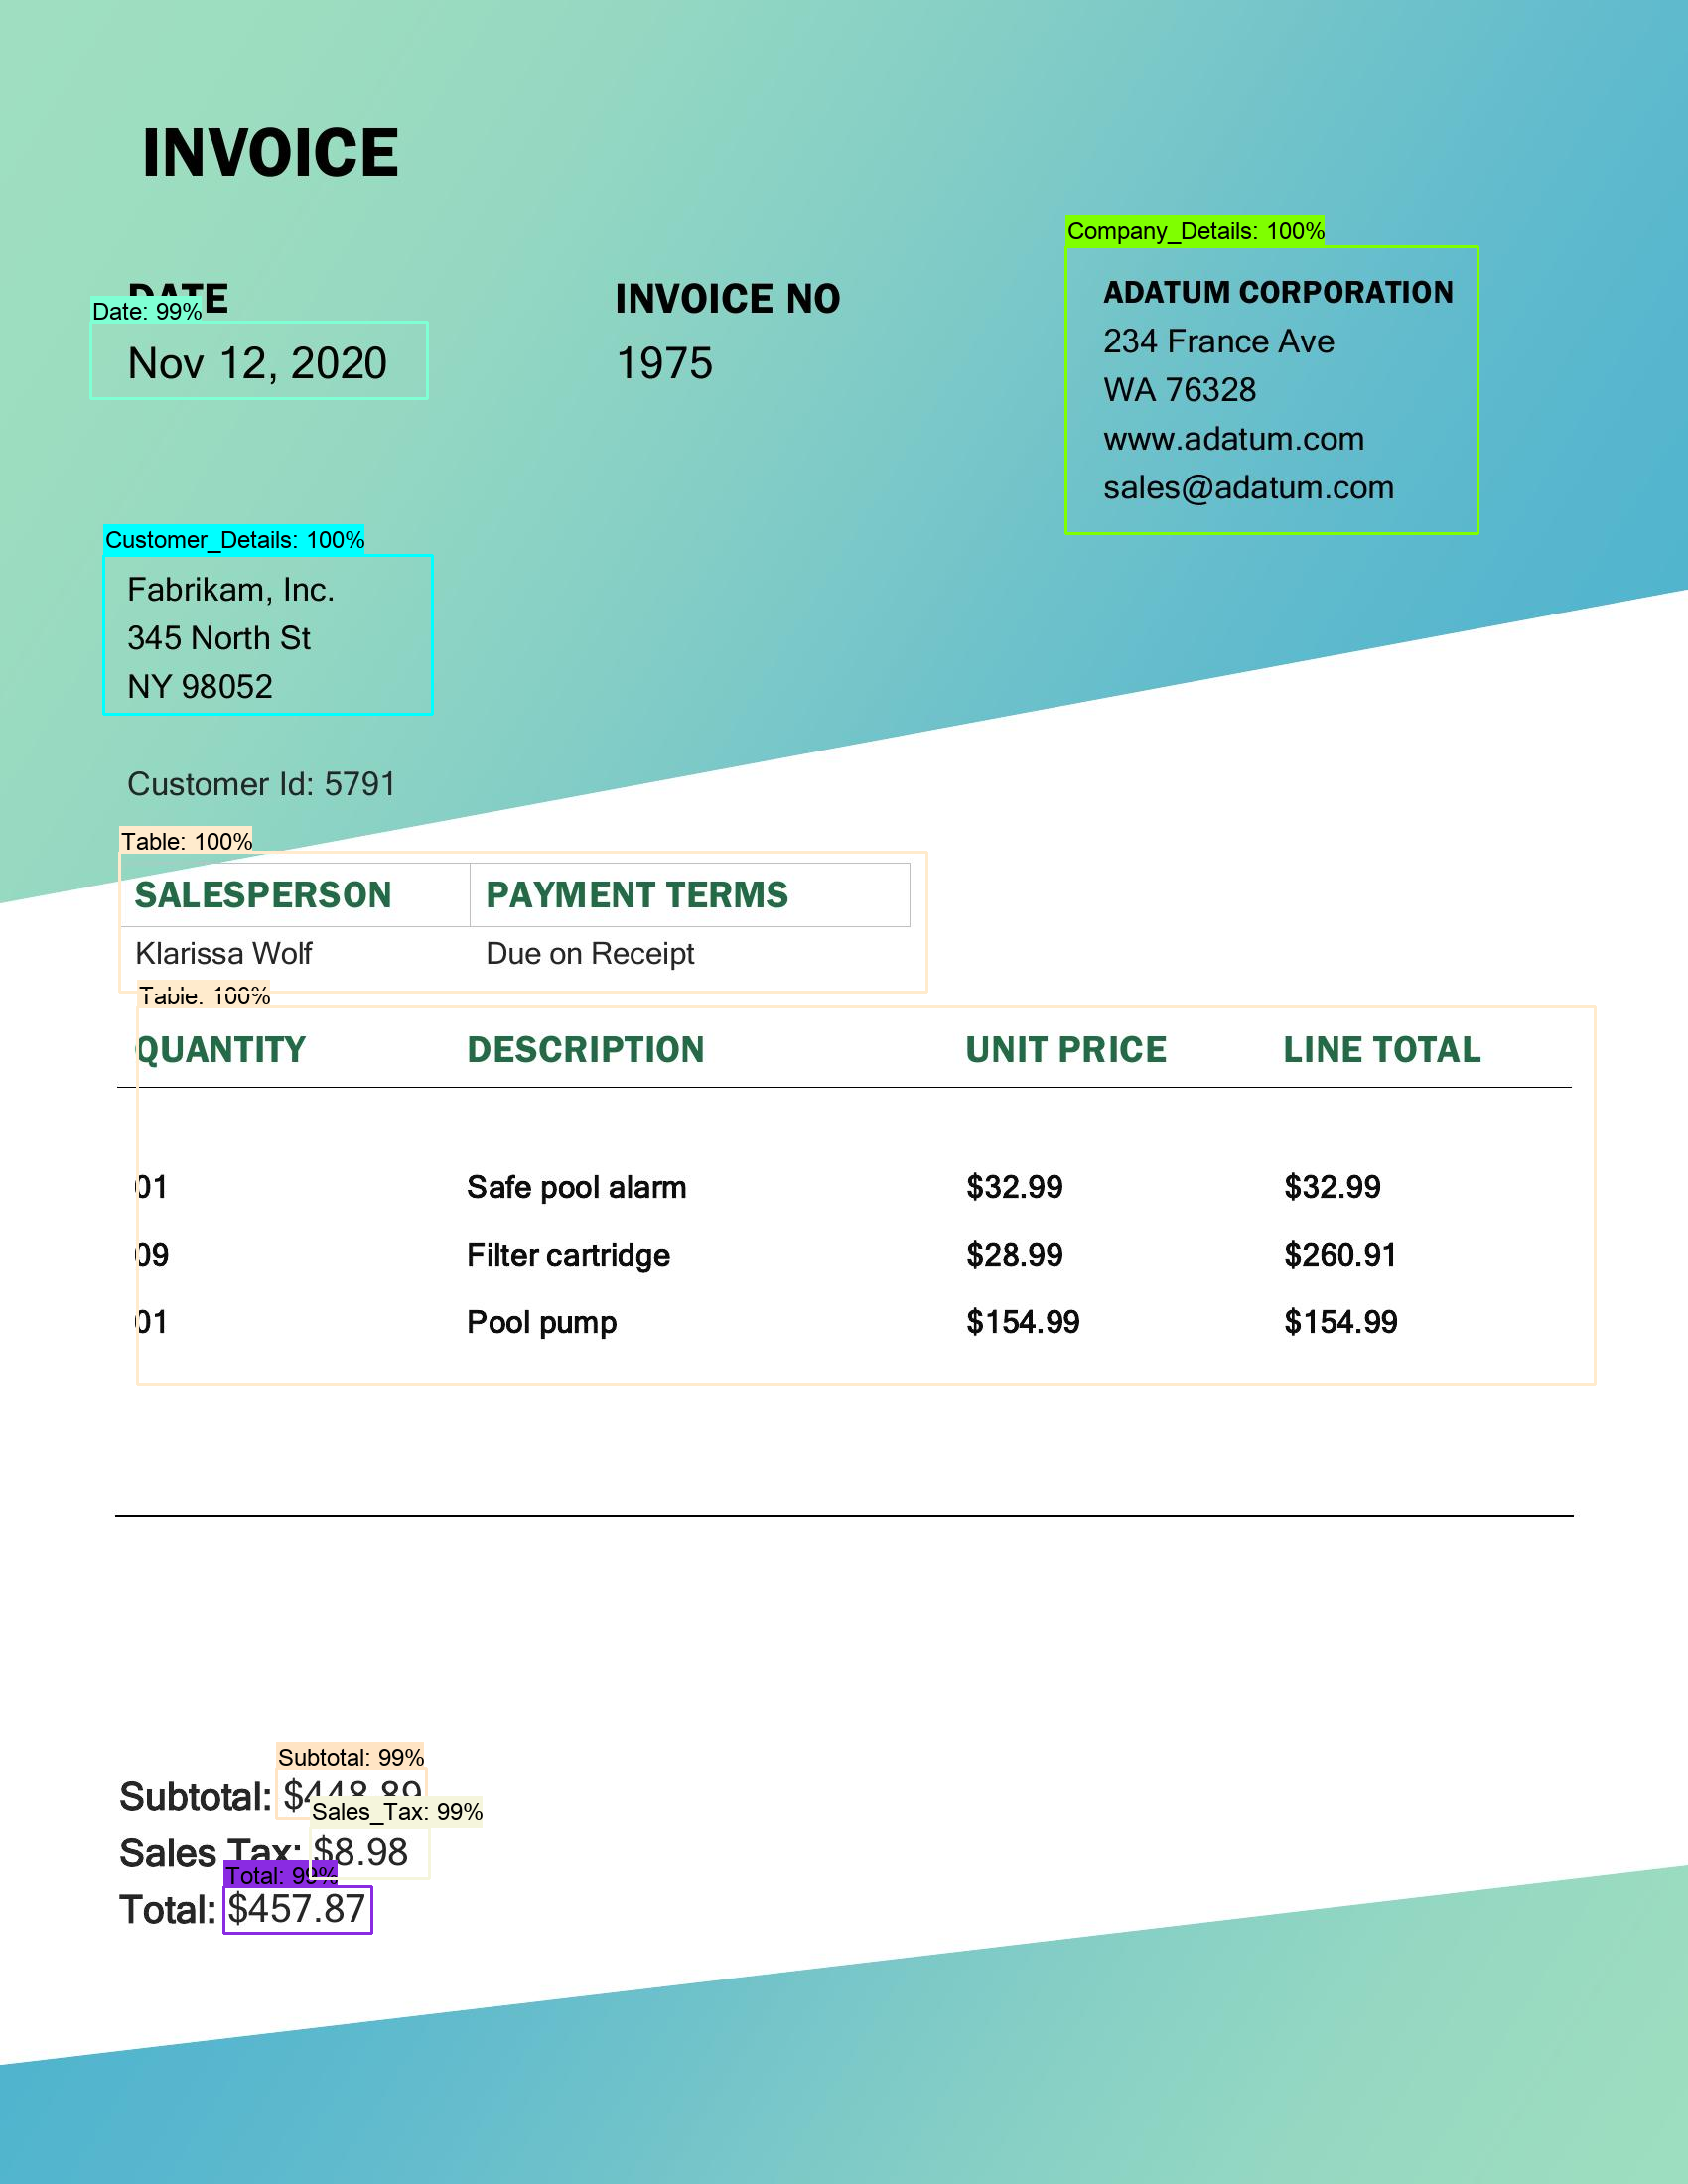

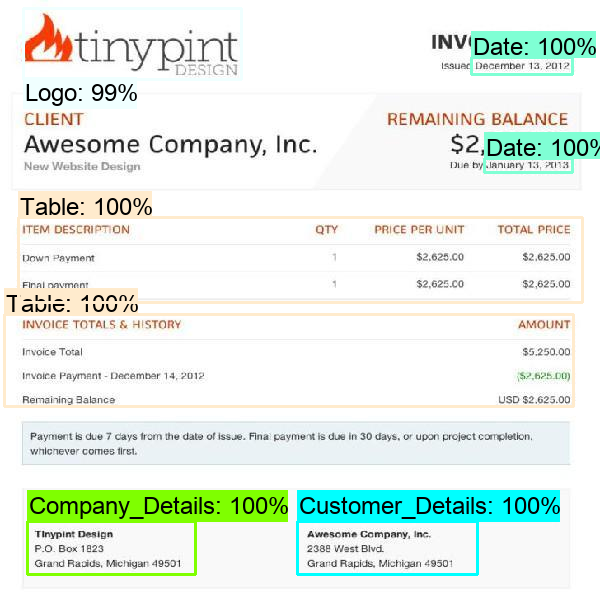

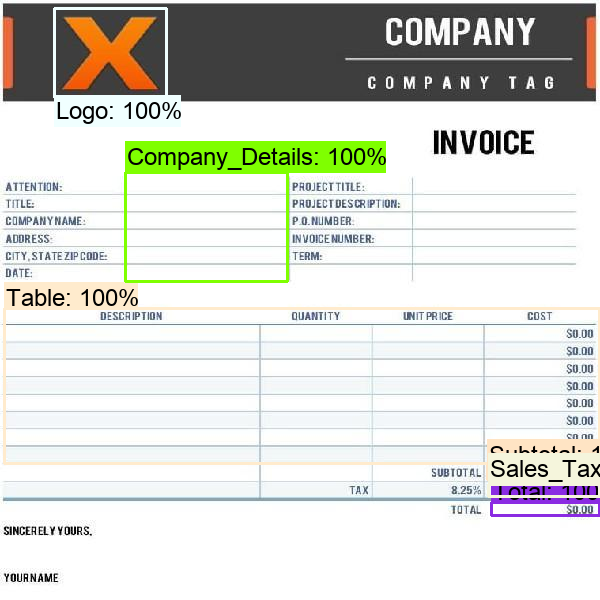

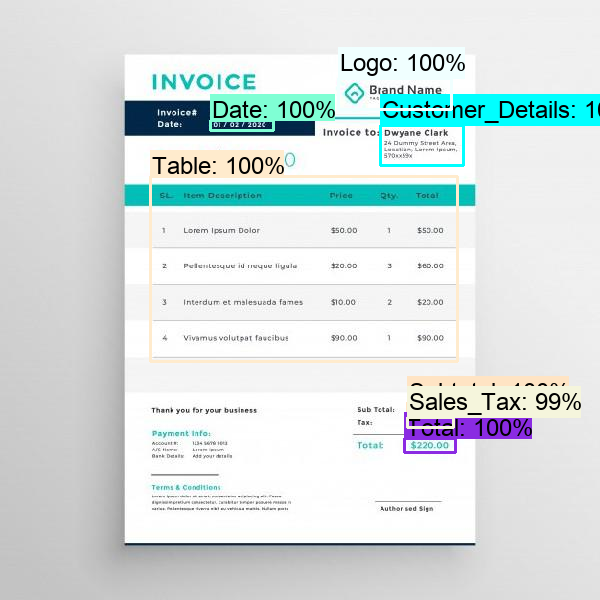

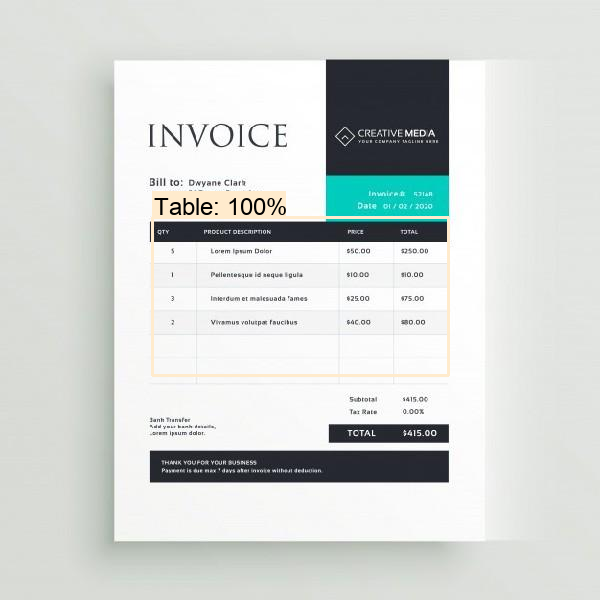

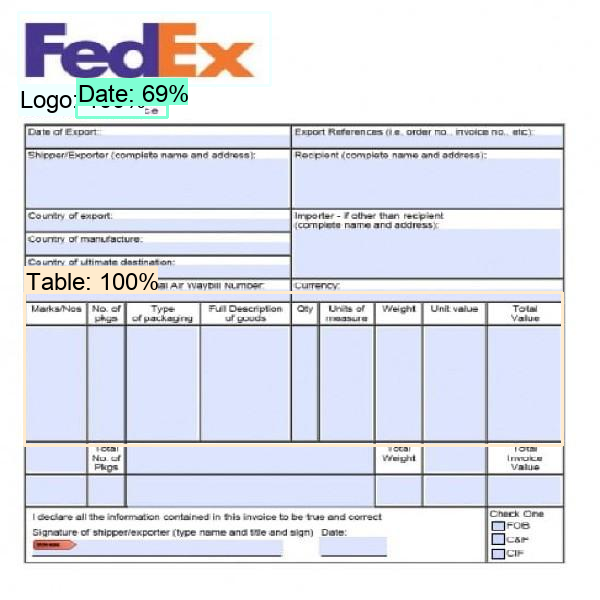

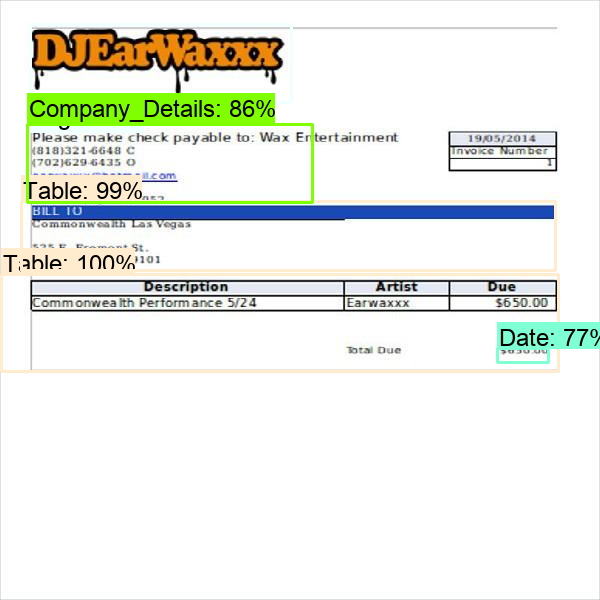

In [8]:
from inferenceutils import *
for image_name in images:
    image_np = load_image_into_numpy_array('test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    display(Image.fromarray(image_np))

## 1.6) Export the predicted coordinates as CSV file

In [9]:
from tqdm import tqdm

rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
for image_name in tqdm(images):
  
    image_np = load_image_into_numpy_array('test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)

    # store boxes in dataframe!
    cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))

    for j in range(cut_off_scores):
        name = image_name
        scores = output_dict['detection_scores'][j]
        classes = output_dict['detection_classes'][j]
        for i in range(1,len(category_index)+1):
            if output_dict['detection_classes'][j] == category_index[i]['id']:
                classes = category_index[i]['name']
        ymin = output_dict['detection_boxes'][j][0]
        xmin = output_dict['detection_boxes'][j][1]
        ymax = output_dict['detection_boxes'][j][2]
        xmax = output_dict['detection_boxes'][j][3]

        row = list([name, scores, classes, ymin, xmin, ymax, xmax])
        rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('dataset/predicted_coordinates.csv', index = False)
final_df

100%|██████████| 7/7 [00:59<00:00,  8.49s/it]


,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,pdf_image_003.jpg,0.999883,Table,0.460709,0.081468,0.633696,0.945221
1,pdf_image_003.jpg,0.999280,Customer_Details,0.254408,0.061293,0.327067,0.256147
2,pdf_image_003.jpg,0.997920,Company_Details,0.112738,0.631518,0.244098,0.875747
3,pdf_image_003.jpg,0.997755,Table,0.390439,0.071166,0.454414,0.549203
4,pdf_image_003.jpg,0.994703,Date,0.147696,0.053840,0.182614,0.253090
5,pdf_image_003.jpg,0.994658,Subtotal,0.809898,0.163827,0.832405,0.252810
6,pdf_image_003.jpg,0.993647,Total,0.863721,0.132572,0.885204,0.220287
7,pdf_image_003.jpg,0.990950,Sales_Tax,0.836801,0.183913,0.860218,0.254437
8,seen_image_001.jpg,0.999760,Table,0.524645,0.006738,0.676925,0.955625
9,seen_image_001.jpg,0.999756,Table,0.361757,0.030462,0.504532,0.970329


# 2) Information Extraction

## 2.1) Import Libraries

In [11]:
import pytesseract
import cv2
import glob
from PIL import Image
import pandas as pd

## 2.2) Read coordinates csv file

In [12]:
coordinates_df = pd.read_csv('dataset/predicted_coordinates.csv')
coordinates_df.head(5)

,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,pdf_image_003.jpg,0.999883,Table,0.460709,0.081468,0.633696,0.945221
1,pdf_image_003.jpg,0.999280,Customer_Details,0.254408,0.061293,0.327067,0.256147
2,pdf_image_003.jpg,0.997920,Company_Details,0.112738,0.631518,0.244098,0.875747
3,pdf_image_003.jpg,0.997755,Table,0.390439,0.071166,0.454414,0.549203
4,pdf_image_003.jpg,0.994703,Date,0.147696,0.053840,0.182614,0.253090


## 2.3) Extract information

In [14]:
from pytesseract import Output
from tqdm import tqdm 

input_path = 'test/'
images = glob.glob1(input_path, "*.jpg")
tessdata_dir_config = r'--tessdata-dir "/home/azzubair/.local/share/tessdata"'

rows = []
for i in tqdm(range(len(coordinates_df))):
    for j in range(len(images)):
        if coordinates_df['Image'][i] == images[j]:
            image = Image.open(input_path+images[j])
            results = pytesseract.image_to_data(image, config=tessdata_dir_config, output_type=Output.DICT)
            
            # (This is not mandatory) 
            width, height = image.size 
              
            # Setting the points for cropped image 
            left   = coordinates_df['xmin'][i]*width
            top    = coordinates_df['ymin'][i]*height
            right  = coordinates_df['xmax'][i]*width
            bottom = coordinates_df['ymax'][i]*height
              
            # Cropped image of above dimension 
            # (It will not change orginal image) 
            im1 = image.crop((left, top, right, bottom)) 
              
            # # Shows the image in image viewer 
            # im1.show() 
            
            text = pytesseract.image_to_string(im1, lang='eng', config=tessdata_dir_config)
            
            row = list([images[j],coordinates_df['Classes'][i], text])
            rows.append(row)

raw_info = pd.DataFrame(rows, columns = ['Image','Key', 'Value'])
raw_info

100%|██████████| 45/45 [01:06<00:00,  1.48s/it]


,Image,Key,Value
0,pdf_image_003.jpg,Table,QUANTITY DESCRIPTION UNIT PRICE LINE TOTAL\n\n...
1,pdf_image_003.jpg,Customer_Details,"Fabrikam, Inc.\n345 North St\nNY 98052\n"
2,pdf_image_003.jpg,Company_Details,ADATUM CORPORATION\n234 France Ave\n\nWA 76328...
3,pdf_image_003.jpg,Table,"""\nSALESPERSON PAYMENT TERMS\n\nKlarissa Wolf ..."
4,pdf_image_003.jpg,Date,"Nov 12, 2020\n"
5,pdf_image_003.jpg,Subtotal,$448.89\n
6,pdf_image_003.jpg,Total,$457.87\n
7,pdf_image_003.jpg,Sales_Tax,$8.98\n
8,seen_image_001.jpg,Table,INVOICE TOTALS & HISTORY AMOUNT\nInvoice Toral...
9,seen_image_001.jpg,Table,ITEM DESCRIFTION QY PRICEPERUNIT TOTAL PRICE\...


### Successfully extracted information from invoices